# How has political sentiment changed over the course of the pandemic?

In [1]:
# Just to keep output tidy - remove later
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

import pandas as pd

from src.data_processing import *
from src.helpers import *
from src.plots import *

In [2]:
DATA_PATH = "./data/"

## Grouping countries by response

We can imagine that countries can be grouped together based on their response to the COVID pandemic.

From `interventions.csv`, we can calculate how long it took for the first measures to be imposed after the first case in the country, and for how long mobility in the country was reduced. Based on these two measures, we can try to find clusters of countries in order to group them.

In [3]:
# Loading data
df_dates = pd.read_csv(DATA_PATH + "interventions.csv", index_col="lang")
# Processing data
df_dates = process_interventions_data(df_dates)

We calculate the Silhouette Score for different numbers of clusters in order to find the optimal number of clusters.

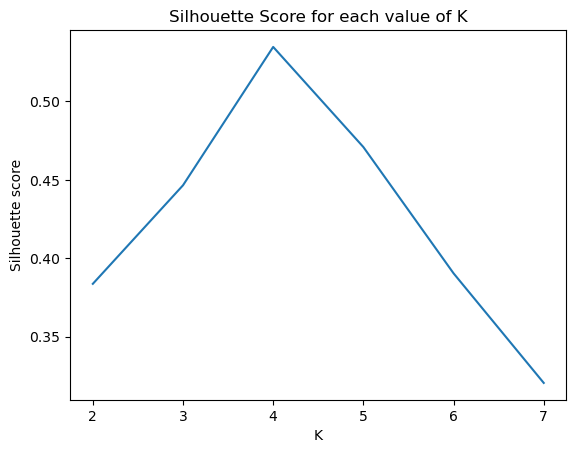

In [4]:
# Select rows where response time and reduced mobility duration are defined
df = df_dates.loc[
    df_dates[["Response time", "Reduced mobility"]].notna().all(1),
    ["Response time", "Reduced mobility"],
]

plot_silhouettes(df, 2, 7)

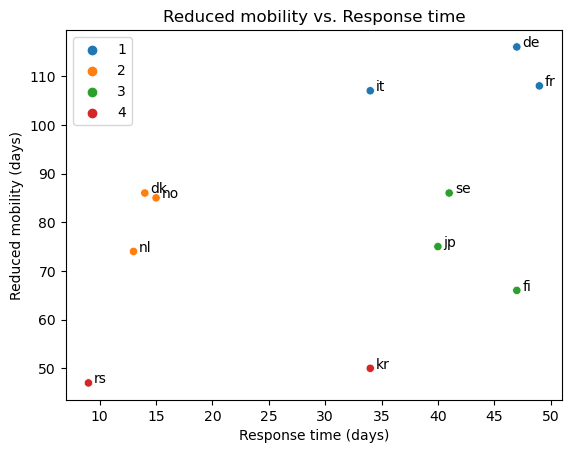

In [5]:
kmeans = KMeans(n_clusters=4, random_state=27).fit(df)

plot_mobility_response(df, kmeans.labels_)

We can identify the following groups of countries:

1. Big European economies which took a long time to react to COVID (possibly due to not wanting to harm the economy) and ended up having long periods of reduced mobility (France, Germany, Italy).

2. Smaller highly developed European countries which reacted quickly to COVID and had shorter periods of reduced mobility (Denmark, Netherlands, Norway).

3. Countries which took longer to react to COVID but had shorter periods of reduced mobility (Finland, Japan, Sweden).

4. Countries with very short periods of reduced mobility (Serbia, South Korea).

Spain is the only country not featured in the plot above. We take a look at its entry in `interventions.csv`.

In [6]:
# Interventions entry for Spain
df_dates.loc["es"]

1st case                2020-01-31 00:00:00
1st death               2020-02-13 00:00:00
School closure          2020-03-12 00:00:00
Public events banned    2020-03-08 00:00:00
Lockdown                2020-03-14 00:00:00
Mobility                2020-03-16 00:00:00
Normalcy                                NaT
Response time                          37.0
Reduced mobility                        NaN
Name: es, dtype: object

The response time was not swift relative to other countries. The datapoint is not plotted due to having an undefined duration of the reduced mobility period, since there is no date for the return to normal mobility levels. We can say that the reduced mobility period is also a long one, which would place Spain in group 1 - big European economies with a long response time and long period of reduced mobility.

## Obtaining polling data

We obtain polling data from [European Opinion Polls as Open Data](https://filipvanlaenen.github.io/eopaod/) - a collection of opinion polls for European countries.

The dataset, understandably, lacks data for Japan and South Korea. Data for Serbia is not present either. Nonetheless, we still have data for 9 of the 12 countries, so we continue working with these countries instead.

Our final groups of countries based on response to the pandemic are:

1. France, Germany, Italy, Spain
2. Denmark, Netherlands, Norway
3. Finland, Sweden

We also have the following geographic groups:

1. Northern Europe - Denmark, Finland, Norway, Sweden
2. Western Europe - France, Germany, Netherlands
3. Southern Europe - Italy, Spain

In [7]:
# Countries grouped by response
response_groups = [
    ["de", "es", "fr", "it"],
    ["dk", "nl", "no"],
    ["fi", "se"],
]

# Countries grouped by geographic region
region_groups = [["dk", "fi", "no", "se"], ["de", "fr", "nl"], ["es", "it"]]

For each country, we plot the polling data for the current 5 most represented parties in parliament (excluding parties founded in 2021 or later). Our error bars represent the standard deviation each month.

In addition, we denote with `*` the main party in government at the beginning of the pandemic and a black line denoting when the first COVID related death occured. This represents the beginning of when the population becomes seriously affected by the virus.

Group 1


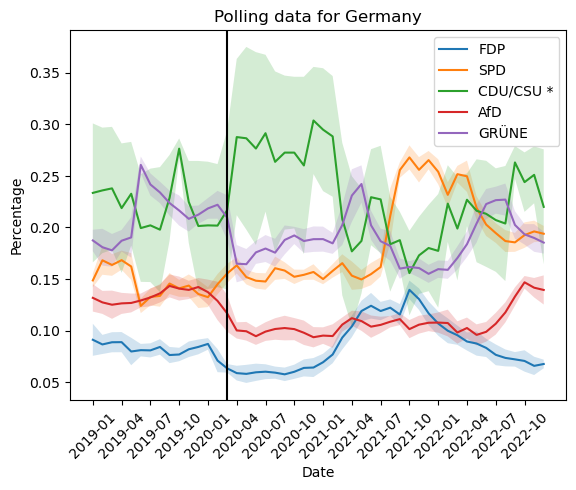

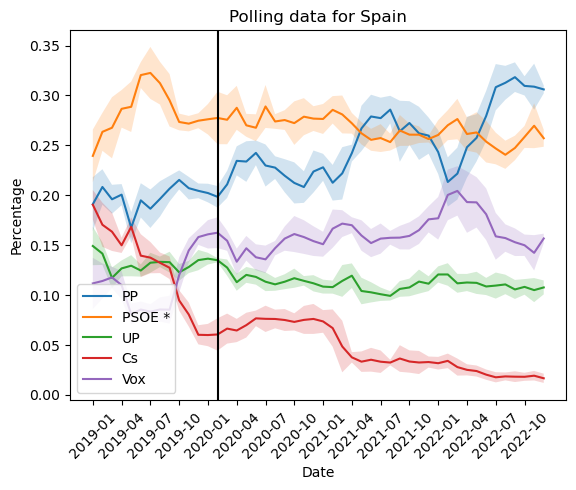

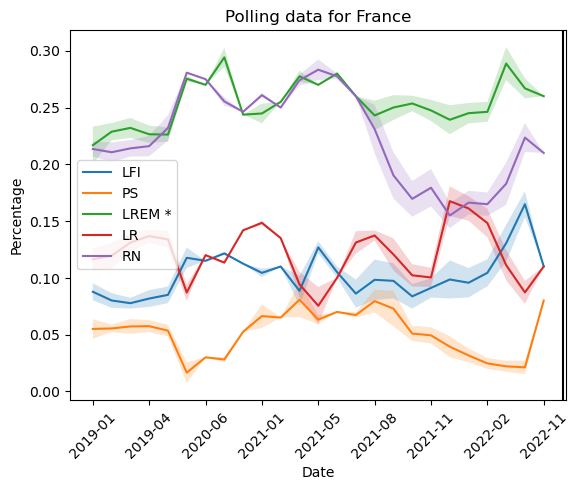

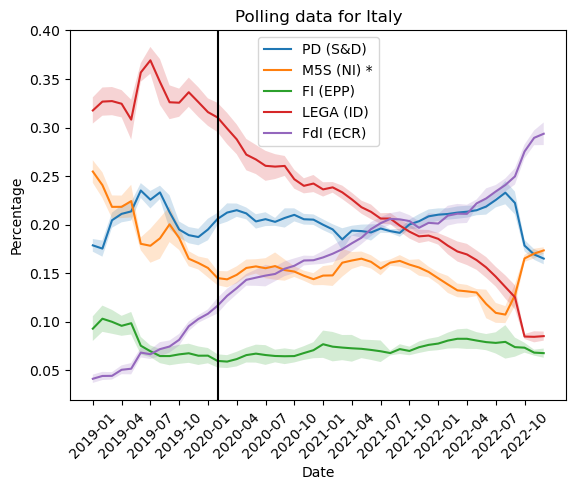

Group 2


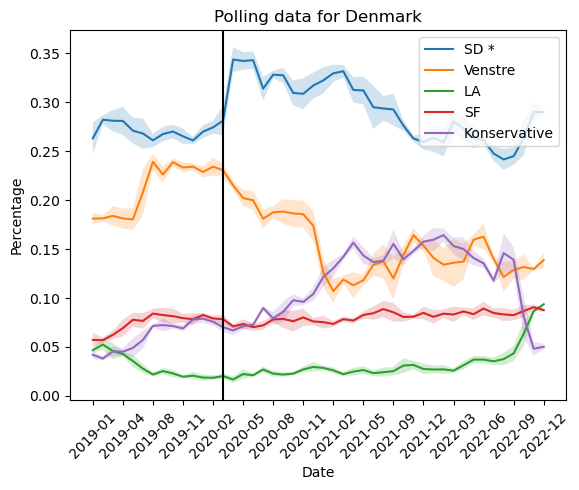

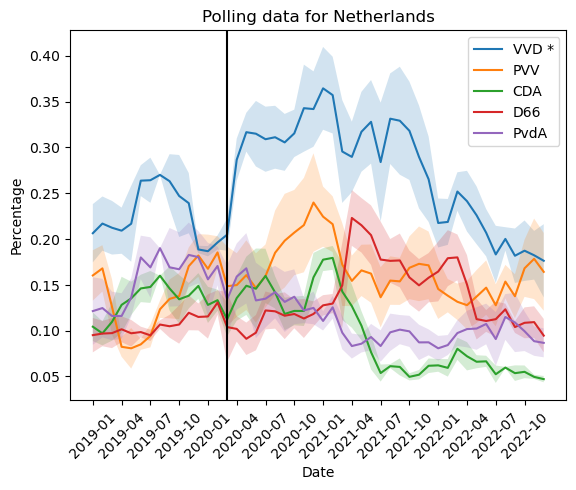

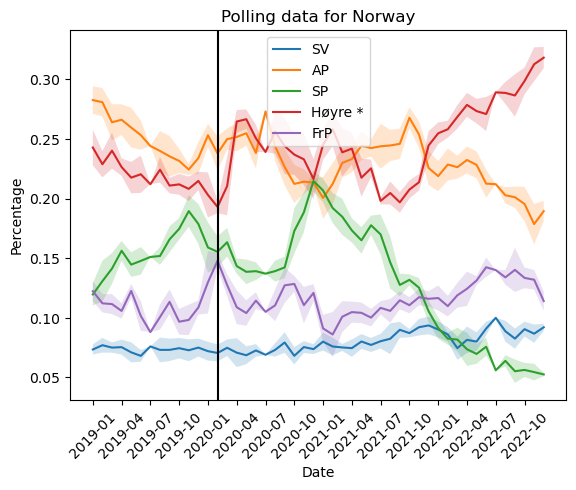

Group 3


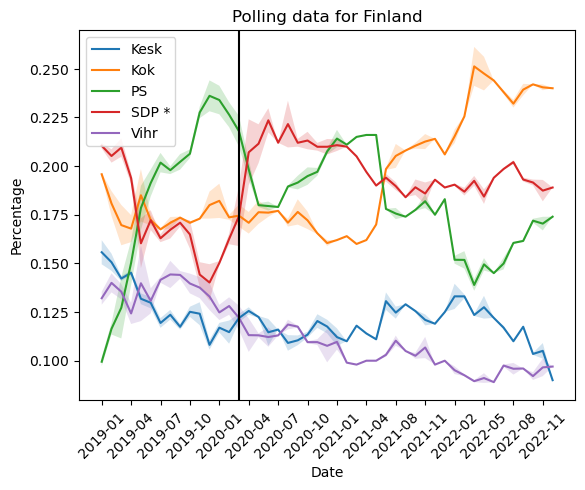

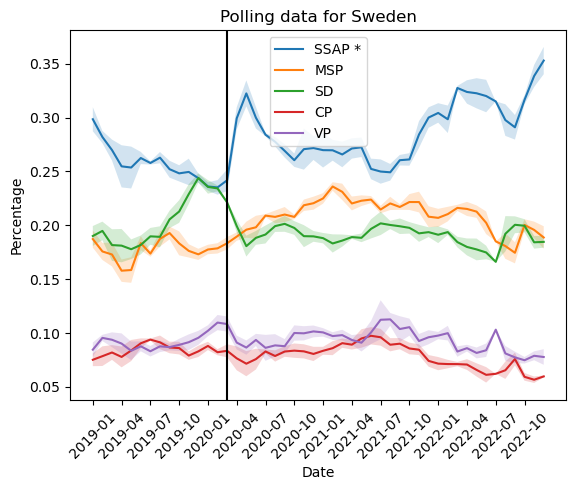

In [8]:
for idx, group in enumerate(response_groups):
    print(f"Group {idx + 1}")
    for country in group:
        df = get_polling_data(country)
        plot_polling_data(df, country, df_dates)

We observe that for countries in group 1 (large economies), the populations reacted differently. In Germany, a sharp rise in popularity for the ruling party was observed, indicating support for stability and implementating sanitary measures. In Spain, it does not look like there is a significant change. In Italy, we observe a continual decrease in support for the main party in government which began before the pandemic itself, indicating domestic issues were more influencial than the pandemic for the party's popularity.

In contrast, countries in group 2 (smaller countries where the government reacted quickly) all observed sudden sharp increases in support for the government. In the case of Norway, the ruling party's steady decrease in popularity was almost entirely negated. This suggests that the populations greatly valued stability and the quick response of their governments.

In group 3, we observe a similar effect whereby support in the government increases. Overall, we see that in smaller countries, government support increased whereas this effect was not observed in all large economies in Europe.

## Interest in politics

Using Wikipedia data, we can look at interest in politics over time.

In [9]:
# Load data
df_pageviews = pd.read_json(DATA_PATH + "aggregated_timeseries.json.gz")

In [10]:
POLITICS = "History and Society.Politics and government"

N_EUROPE = "Geography.Regions.Europe.Northern Europe"
W_EUROPE = "Geography.Regions.Europe.Western Europe"
S_EUROPE = "Geography.Regions.Europe.Southern Europe"

In [11]:
get_pageviews(df_pageviews, "no", "History and Society.Politics and government")

,pageviews
date,
2018-01-01,40377
2018-01-02,45131
2018-01-03,52943
2018-01-04,56377
2018-01-05,51896
...,...
2020-07-27,34576
2020-07-28,35061
2020-07-29,34370


## Analysing mobility data

We can also plot the mobility data with the intervention dates overlayed. This will allow us to see how populations reacted to the pandemic (i.e. did mobility decrease only once governments imposed mobility restrictions, or did people preemptively reduce their own mobility). Alongside the polling data, this could potentially allow us to deduce whether populations had trust in their government. For instance, if government support was high and mobility was reduced before restrictions were imposed (i.e. when governments issued guidance), then it can suggest a high level of trust in the government.

In [12]:
# Load data
df_transport = pd.read_csv(DATA_PATH + "applemobilitytrends-2020-04-20.csv.gz")
df_transport = process_transport_data(df_transport)

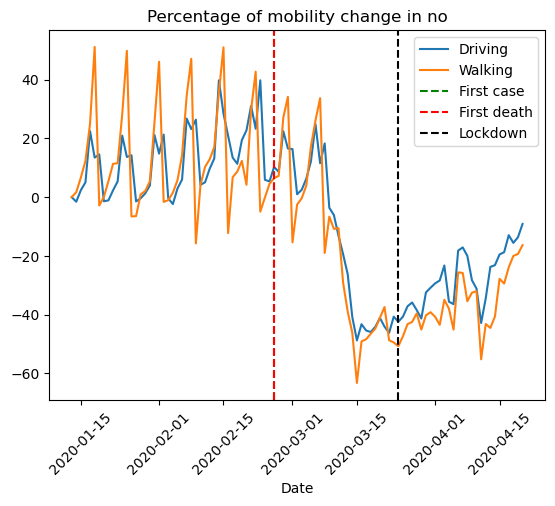

In [13]:
# for idx, group in enumerate(response_groups):
#     print(f"Group {idx + 1}")
#     for country in group:
#         plot_driving_walking_mobility(df_transport, df_dates, country)

plot_driving_walking_mobility(df_transport, df_dates, "no")

In [14]:
# Load data
df_mobility = pd.read_csv(
    DATA_PATH + "Global_Mobility_Report.csv.gz", parse_dates=["date"], low_memory=False,
)
df_mobility = process_mobility_data(df_mobility)

GOOGLE_TITLES = {
    "Retail and recreation change over time": "retail_and_recreation_percent_change_from_baseline",
    "Grocery and pharmacy change over time": "grocery_and_pharmacy_percent_change_from_baseline",
    "Parks change over time": "parks_percent_change_from_baseline",
    "Transit stations change over time": "transit_stations_percent_change_from_baseline",
    "Workplaces change over time": "workplaces_percent_change_from_baseline",
    "Residential change over time": "residential_percent_change_from_baseline"
}


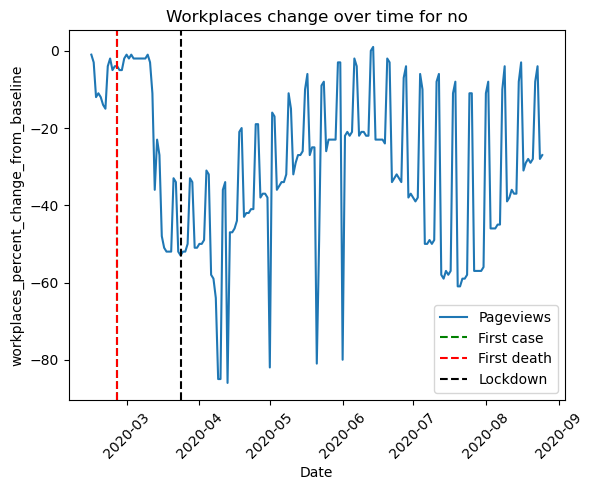

In [16]:
plot_google_mobility(df_mobility, df_dates, GOOGLE_TITLES, "Workplaces change over time", "no")